In [46]:
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import f1_score, jaccard_score
from networkx.algorithms.community.quality import modularity
import numpy as np

In [14]:
import sys
sys.path.append('../')

from algorithms.hierarchical_clustering import hierarchical_clustering

# Data Preparation

In [15]:
def read_data(data_path="../data/emails.txt", labels_path="../data/emails_labels.txt"):
    with open(labels_path, "r") as f:
        nodes_labels = f.read()

    nodes_labels = nodes_labels.strip("\n").split("\n")
    nodes = [int(x.split()[0]) for x in nodes_labels]
    labels = [int(x.split()[1]) for x in nodes_labels]

    with open(data_path, "r") as f:
        edges_data = f.read()

    edges = {x: dict() for x in nodes}
    edges = [(int(x.split()[0]), int(x.split()[1])) for x in edges_data.strip("\n").split("\n")]

    return np.array(edges), np.array(nodes), np.array(labels)

In [16]:
def create_graph(edges, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [17]:
e, n, l = read_data()
e.shape, n.shape, l.shape

((25571, 2), (1005,), (1005,))

In [18]:
G = create_graph(e, n)
G.number_of_edges()

16706

# Sklearn Hierachical Clustering

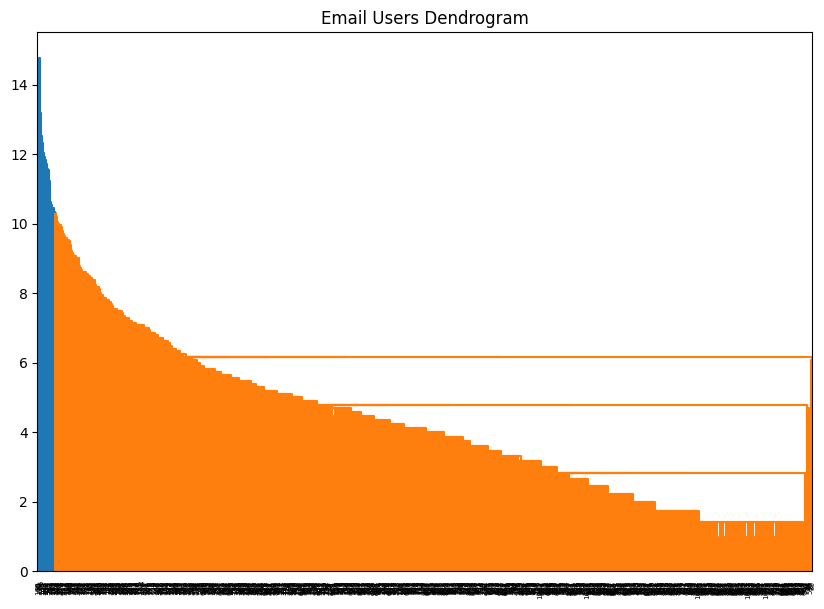

In [19]:
adjacency_matrix = nx.to_numpy_array(G)
distance_matrix = np.where(adjacency_matrix == 0, 1, 0)

L = linkage(distance_matrix, 'single')

max_d = 1
clusters = fcluster(L, max_d, criterion='distance')

node_list = list(G.nodes())

plt.figure(figsize=(10, 7))
plt.title("Email Users Dendrogram")
dendrogram(L)
plt.show()


In [48]:
le = LabelEncoder()
numeric_cluster_labels = le.fit_transform(clusters)

clusters = [set() for _ in range(max(numeric_cluster_labels)+1)]
for node, cluster in zip(G.nodes(), numeric_cluster_labels):
    clusters[cluster].add(node)
mod = modularity(G, clusters)
print(f'Modularity: {mod}')

ari = adjusted_rand_score(l, numeric_cluster_labels)
print(f'Adjusted Rand Index: {ari}')

nmi = normalized_mutual_info_score(l, numeric_cluster_labels)
print(f'Normalized Mutual Information: {nmi}')


mlb = MultiLabelBinarizer()

binary_cluster_assignments = mlb.fit_transform([[label] for label in numeric_cluster_labels])
binary_true_assignments = mlb.transform([[label] for label in l])

f1 = f1_score(binary_true_assignments, binary_cluster_assignments, average='weighted')
print(f'F1 Score: {f1}')

jaccard = jaccard_score(binary_true_assignments, binary_cluster_assignments, average='micro')
print(f'Jaccard Index: {jaccard}')

Modularity: 0.03635821472578154
Adjusted Rand Index: 0.001494325239914611
Normalized Mutual Information: 0.644577466671302
F1 Score: 0.0
Jaccard Index: 0.0


# Own Hierarchical Clustering

In [34]:
communities = hierarchical_clustering(adjacency_matrix, metric="euclidean", linkage="single")

In [42]:
comms = np.ones(len(clusters))

for i, c in enumerate(communities):
    for node in c:
        comms[node] = i

np.set_printoptions(suppress=True)
comms

array([   0.,    1.,    2., ..., 1001., 1002., 1003.])

In [50]:
le = LabelEncoder()
comms = le.fit_transform(comms)

clusters = [set() for _ in range(max(comms)+1)]
for node, cluster in zip(G.nodes(), comms):
    clusters[cluster].add(node)
mod = modularity(G, clusters)
print(f'Modularity: {mod}')


ari = adjusted_rand_score(l, comms)
print(f'Adjusted Rand Index: {ari}')

nmi = normalized_mutual_info_score(l, comms)
print(f'Normalized Mutual Information: {nmi}')


mlb = MultiLabelBinarizer()

binary_cluster_assignments = mlb.fit_transform([[label] for label in comms])
binary_true_assignments = mlb.transform([[label] for label in l])

f1 = f1_score(binary_true_assignments, binary_cluster_assignments, average='weighted')
print(f'F1 Score: {f1}')

jaccard = jaccard_score(binary_true_assignments, binary_cluster_assignments, average='micro')
print(f'Jaccard Index: {jaccard}')

Modularity: 0.03618091198223663
Adjusted Rand Index: 8.09799716293502e-05
Normalized Mutual Information: 0.6486262967064623
F1 Score: 0.001959897482285542
Jaccard Index: 0.0004977600796416127
